In [1]:
#setup environment
import numpy as np 
import pandas as pd 
import os

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
#import data from kaggle database
data_src="/kaggle/input/alzheimer-mri-dataset/Dataset/"

Store image in data array and class label in y array

In [4]:
data=[]
y=[]
for d in os.listdir(data_src):
    for file in os.listdir(data_src+d):
        data.append(Image.open(data_src+d+'/'+file))
        y.append(d)

Convert each image into a numpy array

In [5]:
X=[]
for im in data:
    X.append(np.array(im))

In [6]:
#Convert the list of data into an array
X=np.array(X)

In [7]:
X.shape

(6400, 128, 128)

In [8]:
#Divide by 255 to standardize the values between 0 and 1
X=X/255

MACHINE LEARNING SETUP

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.utils import to_categorical

In [11]:
#count number of each category
non=0
mild=0
mod=0
vm=0
for cat in y:
    if cat=="Mild_Demented":
        mild+=1
    elif cat=="Moderate_Demented":
        mod+=1
    elif cat=="Non_Demented":
        non+=1
    else:
        vm+=1
print("Non Demented: ",non)
print("Very Mild: ",vm)
print("Moderate: ",mod)
print("Mild :",mild)


Non Demented:  3200
Very Mild:  2240
Moderate:  64
Mild : 896


In [12]:
#change labels from word to number to use to_categorical
#0 will be non, 1 will be very mild, 2 will be mild, 3 will be moderate
y_num=[]
for cat in y:
    if cat=="Mild_Demented":
        y_num.append(2)
    elif cat=="Moderate_Demented":
        y_num.append(3)
    elif cat=="Non_Demented":
        y_num.append(0)
    else:
        y_num.append(1)

In [13]:
#convert to a categorical target as expected by keras
y=to_categorical(y_num)

In [14]:
y.shape

(6400, 4)

In [15]:
#Reshape to use in a neural network
X=X.reshape(6400,128,128,1)

In [16]:
#Split into a training set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=25)

In [17]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(4800, 128, 128, 1) (1600, 128, 128, 1) (4800, 4) (1600, 4)


In [18]:
#Create the model
cnn=Sequential()
#initially 64 convolution nodes
cnn.add(Conv2D(64,(3,3),padding="same",activation='relu',input_shape=X_train.shape[1:]))
#add a Max Pooling layer
cnn.add(MaxPooling2D())
#another 32 convolution nodes
cnn.add(Conv2D(32,(3,3),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())
#Add 32 convolutions
cnn.add(Conv2D(32,(3,3),padding="same",activation='relu'))
#Add a max pooling
cnn.add(MaxPooling2D())
#Flatten before adding fully connected layer
cnn.add(Flatten())
#Add a hidden layer with 100 nodes
cnn.add(Dense(100,activation='relu'))
#Add final output layer with 4 output nodes using softmax
cnn.add(Dense(4,activation='softmax'))

2022-04-24 22:01:34.915655: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [20]:
cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')

In [21]:
#Train the Convolutional Neural Network on the data
history=cnn.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test))

2022-04-24 22:01:35.960182: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
150/150 [==============================] - 55s 360ms/step - loss: 1.0172 - accuracy: 0.5046 - val_loss: 0.9823 - val_accuracy: 0.5144
Epoch 2/25
150/150 [==============================] - 54s 358ms/step - loss: 0.8942 - accuracy: 0.5948 - val_loss: 0.8258 - val_accuracy: 0.6087
Epoch 3/25
150/150 [==============================] - 53s 356ms/step - loss: 0.7155 - accuracy: 0.6852 - val_loss: 0.5873 - val_accuracy: 0.7375
Epoch 4/25
150/150 [==============================] - 54s 358ms/step - loss: 0.4726 - accuracy: 0.8023 - val_loss: 0.4236 - val_accuracy: 0.8144
Epoch 5/25
150/150 [==============================] - 54s 359ms/step - loss: 0.2878 - accuracy: 0.8908 - val_loss: 0.3129 - val_accuracy: 0.8869
Epoch 6/25
150/150 [==============================] - 54s 359ms/step - loss: 0.1608 - accuracy: 0.9415 - val_loss: 0.2308 - val_accuracy: 0.9144
Epoch 7/25
150/150 [==============================] - 54s 359ms/step - loss: 0.0841 - accuracy: 0.9733 - val_loss: 0.1912 - val_ac

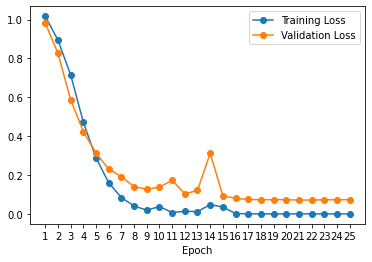

In [22]:
#Plot to see how the loss function changed
plt.plot(range(1,26),history.history['loss'],marker="o")
plt.plot(range(1,26),history.history['val_loss'],marker="o")
plt.legend(["Training Loss","Validation Loss"])
plt.xlabel("Epoch")
plt.xticks(range(1,26))
plt.show()

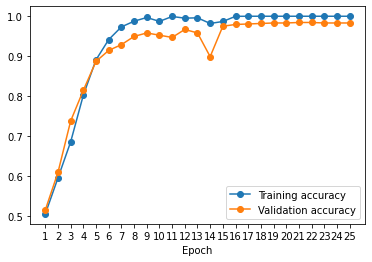

In [23]:
#plot to see how the accuracy changed
plt.plot(range(1,26),history.history['accuracy'],marker="o")
plt.plot(range(1,26),history.history['val_accuracy'],marker="o")
plt.legend(["Training accuracy","Validation accuracy"])
plt.xlabel("Epoch")
plt.xticks(range(1,26))
plt.show()

In [24]:
#Get a prediction from the neural network
y_pred=cnn.predict(X_test)

In [25]:
#The prediction is a sequence of 4 probabilities. We choose the label with the highest probability
y_val=[]
for y in y_pred:
    y_val.append(np.argmax(y))

In [26]:
from sklearn.metrics import confusion_matrix,classification_report

In [27]:
#Convert back to labels 0-3
y_true=[]
for y in y_test:
    y_true.append(np.argmax(y))

In [28]:
#Let's see how the predictions did
print(confusion_matrix(y_true,y_val))

[[808  12   1   0]
 [  5 547   1   0]
 [  1   7 207   0]
 [  0   0   0  11]]


In [29]:
print(classification_report(y_true,y_val))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       821
           1       0.97      0.99      0.98       553
           2       0.99      0.96      0.98       215
           3       1.00      1.00      1.00        11

    accuracy                           0.98      1600
   macro avg       0.99      0.98      0.99      1600
weighted avg       0.98      0.98      0.98      1600



In [30]:
from sklearn.metrics import accuracy_score

In [31]:
print("Accuracy on test data: ",accuracy_score(y_true,y_val))

Accuracy on test data:  0.983125
